In [1]:
# Load bunch of necessary packages

import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

In [5]:
# Normal traffice list

train_dataset = pd.read_csv('https://raw.githubusercontent.com/KnightChaser/ML-challenge/main/EX_challenging_problems/09_AE_malicious_traffic_detection/normal_traffic_list.csv')
test_dataset  = pd.read_csv('https://raw.githubusercontent.com/KnightChaser/ML-challenge/main/EX_challenging_problems/09_AE_malicious_traffic_detection/anomaly_traffic_list.csv')

<ipython-input-7-781819eb8ad5>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = train_dataset.corr()


<Axes: >

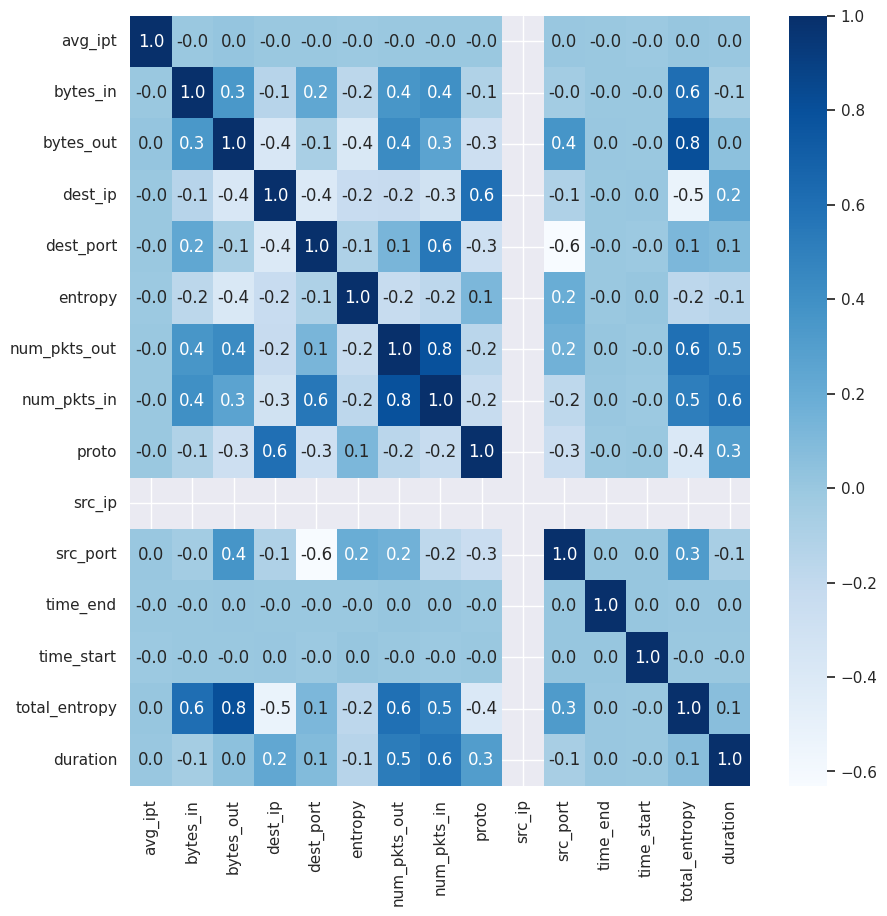

In [7]:
correlation = train_dataset.corr()

# heatmap to express correlation
plt.figure(figsize = (10,10))
sns.set(font_scale = 1)
sns.heatmap(correlation, annot = True, cbar = True, cmap = "Blues", fmt = '.1f')        # Blue, Blue, I love Blue

In [9]:
train_dataset = train_dataset[['bytes_in', 'bytes_out', 'entropy', 'duration', 'label', 'num_pkts_in', 'num_pkts_out']]
test_dataset  = test_dataset[['bytes_in', 'bytes_out', 'entropy', 'duration', 'label', 'num_pkts_in', 'num_pkts_out']]

print(f'train_dataset\'s shape: {train_dataset.shape}')
print(f'train_dataset\'s null?: {train_dataset.isnull().values.any()}')

print(f'test_dataset\'s shape: {test_dataset.shape}')
print(f'test_dataset\'s null?: {test_dataset.isnull().values.any()}')

train_dataset's shape: (43778, 7)
train_dataset's null?: False
test_dataset's shape: (26167, 7)
test_dataset's null?: False


In [10]:
test_dataset.isnull().sum(axis=0)
test_dataset = test_dataset.dropna(axis = 0)

print(f'test_dataset\'s shape: {test_dataset.shape}')
print(f'test_dataset\'s null?: {test_dataset.isnull().values.any()}')

test_dataset's shape: (26167, 7)
test_dataset's null?: False


In [11]:
# from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

X_train, X_validation = train_test_split(train_dataset, test_size = 0.1, random_state = 0xCAFE)
X_train = X_train.drop(['label'], axis = 1)
X_validation = X_validation.drop(['label'], axis = 1)

X_test = test_dataset.drop(['label'], axis = 1)
y_test = test_dataset['label']

le = LabelEncoder()
le.fit(y_test)
y_test = le.transform(y_test)

print(f'X_train\'s shape: {X_train.shape}')
print(f'X_validation\'s shape: {X_validation.shape}')
print(f'y_test\'s shape: {y_test.shape}')
print(f'X_test\'s shape: {X_test.shape}')

X_train's shape: (39400, 6)
X_validation's shape: (4378, 6)
y_test's shape: (26167,)
X_test's shape: (26167, 6)


In [12]:
# Autoencoder model
input_dim = X_train.shape[1]
encoding_dim = 64

input_layer = Input(shape=(input_dim, ))

encoder1 = Dense(encoding_dim,
                 activation = "tanh",
                 activity_regularizer = regularizers.l1(10e-5))(input_layer)
encoder2 = Dense(int(encoding_dim / 2), activation="relu")(encoder1)
encoder3 = Dense(int(encoding_dim / 4), activation="relu")(encoder2)

decoder1 = Dense(int(encoding_dim / 4), activation='tanh')(encoder3)
decoder2 = Dense(int(encoding_dim / 2), activation='tanh')(decoder1)
decoder3 = Dense(int(encoding_dim), activation='tanh')(decoder2)

decoder = Dense(input_dim, activation='relu')(decoder3)
autoencoder = Model(inputs=input_layer, outputs=decoder)

In [13]:

nb_epoch = 15
batch_size = 32
autoencoder.compile(optimizer = 'adam',
                    loss = 'mean_squared_error',
                    metrics = ['accuracy'])

checkpoint = ModelCheckpoint(filepath = "best-model.h5",
                               verbose = 0,
                               save_best_only = True)

history = autoencoder.fit(X_train, X_train,
                    epochs = nb_epoch,
                    batch_size = batch_size,
                    shuffle = True,
                    validation_data = (X_validation, X_validation),
                    verbose = 1,
                    callbacks = [checkpoint]).history

Epoch 1/15
1232/1232 [==============================] - 15s 5ms/step - loss: 65986008.0000 - accuracy: 0.7741 - val_loss: 68678800.0000 - val_accuracy: 0.8047
Epoch 2/15
1232/1232 [==============================] - 7s 5ms/step - loss: 65629292.0000 - accuracy: 0.8012 - val_loss: 68321656.0000 - val_accuracy: 0.8047
Epoch 3/15
1232/1232 [==============================] - 6s 5ms/step - loss: 65286132.0000 - accuracy: 0.8012 - val_loss: 67970872.0000 - val_accuracy: 0.8047
Epoch 4/15
1232/1232 [==============================] - 7s 5ms/step - loss: 64947380.0000 - accuracy: 0.8008 - val_loss: 67623096.0000 - val_accuracy: 0.8047
Epoch 5/15
1232/1232 [==============================] - 6s 5ms/step - loss: 64612156.0000 - accuracy: 0.8012 - val_loss: 67278688.0000 - val_accuracy: 0.8047
Epoch 6/15
1232/1232 [==============================] - 7s 5ms/step - loss: 64279856.0000 - accuracy: 0.8012 - val_loss: 66937988.0000 - val_accuracy: 0.8047
Epoch 7/15
1232/1232 [=============================

In [14]:
predictions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})
error_df.describe()

818/818 [==============================] - 2s 2ms/step


,reconstruction_error,true_class
count,2.616700e+04,26167.000000
mean,1.933949e+07,1.650399
std,1.020649e+08,0.658607
min,6.826572e-01,0.000000
25%,3.488515e+00,2.000000
50%,3.265497e+05,2.000000
75%,3.866347e+05,2.000000
max,1.293819e+09,2.000000


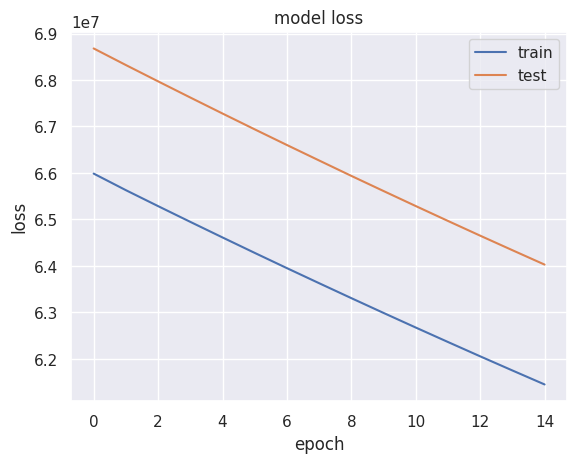

In [15]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');


### Looks like this model is inappropriate for the darknet traffic dataset....